In [1]:
# System
import os

# Data processing
import numpy as np

# Results presentation
from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# NN related stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

%matplotlib inline

In [2]:
N_CELLS_HOR = 200
N_CELLS_VER = 250

In [3]:
celled_data = torch.load("Data/celled_data_"
                         + str(N_CELLS_HOR)
                         + "x"
                         + str(N_CELLS_VER))
print (celled_data.shape)

torch.Size([9591, 1, 200, 250])


In [4]:
DEVICE_ID = 6
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(DEVICE_ID)
print (DEVICE)

cuda


### Создадим датасет

In [5]:
OBSERVED_DAYS = 64     # ~2 months
DAYS_TO_PREDICT_AFTER  = 10
DAYS_TO_PREDICT_BEFORE = 50
TESTING_DAYS = 1000

HEAVY_QUAKE_THRES = 3.5

In [6]:
freq_map = (celled_data>HEAVY_QUAKE_THRES).float().mean(dim=0)

In [7]:
print (freq_map.shape)

torch.Size([1, 200, 250])


In [8]:
class Dataset_RNN_Train (Dataset):
    def __init__(self, celled_data):
        self.data = celled_data[0:
                                (celled_data.shape[0] -
                                 TESTING_DAYS)]
        self.size = (self.data.shape[0] -
                     DAYS_TO_PREDICT_BEFORE)
        
        print ('self.data :', self.data.shape)
        print ('size      :', self.size)
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return (self.data[idx],
                torch.sum(self.data[(idx +
                                     DAYS_TO_PREDICT_AFTER):
                                    (idx +
                                     DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
                          dim=0,
                          keepdim=True).squeeze(0) > 0)
        



In [9]:
# class Dataset_RNN_Train (Dataset):
#     def __init__(self, celled_data):
#         self.data = celled_data[0:
#                                 (celled_data.shape[0] -
#                                  TESTING_DAYS)]
        
#         self.size = (self.data.shape[0] -
#                      DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         accurate_pred = ((torch.sum(self.data[(idx +
#                                               DAYS_TO_PREDICT_AFTER):
#                                              (idx +
#                                               DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
#                                    dim=0,
#                                    keepdim=True).squeeze(0) > 0).float()
#                          - freq_map)
#         return (self.data[(idx)],
#                 torch.cat([1 - accurate_pred, accurate_pred], dim=0))
        

# class Dataset_RNN_Test (Dataset):
#     def __init__(self, celled_data):
#         self.data = celled_data[(celled_data.shape[0] -
#                                  TESTING_DAYS):
#                                 (celled_data.shape[0])]
#         self.size = (self.data.shape[0] -
#                      DAYS_TO_PREDICT_BEFORE)
        
#         print ('self.data :', self.data.shape)
#         print ('size      :', self.size)
        
#     def __len__(self):
#         return self.size
    
#     def __getitem__(self, idx):
#         return (self.data[(idx)],
#                 torch.sum(self.data[(idx +
#                                      DAYS_TO_PREDICT_AFTER):
#                                     (idx +
#                                      DAYS_TO_PREDICT_BEFORE)] > HEAVY_QUAKE_THRES,
#                           dim=0,
#                           keepdim=True).squeeze(0) > 0)

In [10]:
dataset_train = Dataset_RNN_Train (celled_data)

dataloader_train = DataLoader(dataset_train,
                              batch_size=1,
                              shuffle=False,
                              num_workers=1)


self.data : torch.Size([8591, 1, 200, 250])
size      : 8541


In [11]:
# def CrossEntropyLoss(weights, prediction, target):
#     assert len(weights) == prediction.shape[1]
#     assert prediction.shape == target.shape
#     loss = 0
#     for i in range(prediction.shape[0]):
#         for j in range(len(weights)):
#             loss -= weights[j] * torch.sum(target[i, j] * prediction[i, j].log())
#     return loss / prediction.shape[0] / prediction.shape[2] / prediction.shape[3]

In [12]:
def any_errors (tensor):
    for el1 in tensor:
        for el2 in el1:
            for el3 in el2:
                for el4 in el3:
                    if el4 >= 1 or el4 <= 0:
                        return True
    return False

In [13]:
def train_network_RNN (RNN_cell,
                       device,
                       dataloader_train,
                       n_cycles=1,
                       learning_rate=0.0003,
                       earthquake_weight=1.,
                       lr_decay=1.):
    
    loss_massive = []
    
    RNN_cell.to(device)
    
    weights = torch.tensor([1., earthquake_weight], dtype=torch.float).to(device)
    criterion = nn.CrossEntropyLoss(weights)
    
    i = 0
    for cycle in range(n_cycles):
        
        optimizer = torch.optim.Adam(RNN_cell.parameters(), lr=learning_rate)
        optimizer.zero_grad()
        
        hid_state = RNN_cell.init_state(batch_size=1, device=device)
        for data in dataloader_train:
            
            inputs = data[0].to(device)
            labels = data[1].to(device)
            
            hid_state, outputs = RNN_cell.forward(inputs, hid_state)
            
#             print ('outputs :', outputs.shape)
#             print ('outputs :', outputs[0, :, 150:155, 150:155])
#             print ('Error : ', any_errors(outputs))
#             loss = CrossEntropyLoss(weights, outputs, labels)
            loss = criterion(outputs, labels.squeeze(0).long())
#             print ('loss :', loss.item())
            loss_massive.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if (type(hid_state) == tuple):
                for elem in hid_state:
                    elem.detach_()
            else:
                hid_state.detach_()
            
#             if i == 1:
#                 break
            if (i)%100==0:
                clear_output(True)
                print ("Done :", i, "/", dataloader_train.__len__() * n_cycles)
                plt.plot(loss_massive,label='loss')
                plt.legend()
                plt.show()
            i += 1
        learning_rate /= lr_decay
         

In [15]:
N_CYCLES = 3
LEARNING_RATE = 0.0003
LR_DECAY = 10.
EARTHQUAKE_WEIGHT = 10000.

EMB_SIZE = 16
HID_SIZE = 32

In [14]:
from model import LSTMCell

Done : 25600 / 25623


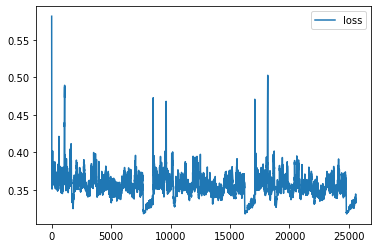

In [16]:
# RNN_cell = RNNCell()
RNN_cell = LSTMCell(freq_map,
                    embedding_size    = EMB_SIZE,
                    hidden_state_size = HID_SIZE,
                    n_cells_hor       = N_CELLS_HOR,
                    n_cells_ver       = N_CELLS_VER,
                    device            = DEVICE)
train_network_RNN (RNN_cell,
                   DEVICE,
                   dataloader_train,
                   n_cycles=N_CYCLES,
                   learning_rate=LEARNING_RATE,
                   earthquake_weight=EARTHQUAKE_WEIGHT,
                   lr_decay=LR_DECAY
                   )

In [17]:
torch.save(RNN_cell.state_dict(), "model_state_dict")

In [18]:
def check_quality (RNN_cell,
                   device,
                   dataloader_test,
                   n_dots=501,
                   info_file=None):
    
    prediction = torch.zeros(dataloader_test.__len__(),  N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    prediction.detach_()
    target     = torch.zeros(dataloader_test.__len__(), N_CELLS_HOR, N_CELLS_VER,
                             device=device,
                             dtype=torch.float)
    target.detach_()
       
    RNN_cell.to(device)

    hid_state = RNN_cell.init_state(batch_size=1, device=device)
    if (type(hid_state) == tuple):
        for elem in hid_state:
            elem.detach_()
    else:
        hid_state.detach_()
        
    i = 0
    for data in tqdm(dataloader_test):

        inputs = data[0].to(device)
        labels = data[1].to(device).float()

        hid_state, outputs = RNN_cell.forward(inputs, hid_state)
        
        prediction[i] = outputs[:, 1, :, :]
        target    [i] = labels.squeeze(0)
    
        if (type(hid_state) == tuple):
            for elem in hid_state:
                elem.detach_()
        else:
            hid_state.detach_()
        prediction.detach_()
        target    .detach_()
        i += 1
        
    assert prediction.shape == target.shape
    prediction = prediction [10:prediction.shape[0]]  # cutting peace of data because
    target     = target     [10:target    .shape[0]]  # hidden state might be not good
    
    print ("ROC_AUC_score = ", end='')
    ROC_AUC_score = roc_auc_score(np.array(target    .view(-1).cpu()),
                                  np.array(prediction.view(-1).cpu()))
    print (ROC_AUC_score)
    
    print ("AVG_precision_score = ", end='')
    AVG_precision_score = average_precision_score(np.array(target    .view(-1).cpu()),
                                                  np.array(prediction.view(-1).cpu()))
    print (AVG_precision_score)
        
    print ('\n=======================')
    
    for threshold in (0.2, 0.4, 0.6, 0.8):
        print ('Threshold = ', threshold)
        print ('-----------------------')
        print (my_TP_FN_FP_TN(prediction, target, threshold))
        print ('=======================')
    
    
    threshold_massive = torch.linspace (0, 1, n_dots, dtype=torch.float, device=device)
    
#     precision = np.zeros(n_dots)
#     recall    = np.zeros(n_dots)
#     FPR       = np.zeros(n_dots)

    precision_massive = []
    recall_massive    = []
    FPR_massive       = []
    
    for threshold in tqdm(threshold_massive):
        precision, recall, FPR = my_precision_TPR_FPR(prediction, target, threshold)
        precision_massive.append(precision.item())
        recall_massive   .append(recall.item())
        FPR_massive      .append(FPR.item())
    
    # plot 1 precision
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), precision_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('precision')

    plt.show()
    
    # plot 2 recall
    fig = plt.figure(figsize=(10, 6))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(np.array(threshold_massive.cpu()), recall_massive, color='green', marker='^')

    axes.set_xlabel('threshold')
    axes.set_ylabel('recall')
    
    plt.show()
    
    # plot 3 ROC-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(FPR_massive, recall_massive, 'orange', marker = '^')
    axes.plot (range(2), range(2), 'grey', ls='--')

    axes.set_xlabel('FPR')
    axes.set_ylabel('TPR (recall)')
    axes.set_title('ROC-curve')

    plt.show()
    
    # plot 4 precision-recall-curve
    fig = plt.figure(figsize=(8, 8))

    axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    axes.plot(recall_massive, precision_massive, 'orange', marker = '^')

    axes.set_xlabel('Recall')
    axes.set_ylabel('Precision')
    axes.set_title('Precision_Recall_curve')

    plt.show()
    
    return ROC_AUC_score, AVG_precision_score

In [19]:
def my_accuracy (input, target, threshold):
    true = ((input>threshold) == target)
    sum = torch.sum (true.float())
    return sum/input.shape[0]/input.shape[1]/input.shape[2]/input.shape[3]

def my_precision (input, target, threshold):
    TP = torch.sum (((input>threshold) * target      ).float())
    FP = torch.sum (((input>threshold) * (1 - target)).float())
    return TP / (TP + FP)

def my_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target).float())
    FN = torch.sum (((1 - (input>threshold)) * target).float())
    return TP / (TP + FN)

def my_precision_recall (input, target, threshold):
    TP = torch.sum ((     (input>threshold)  * target      ).float())
    FP = torch.sum ((     (input>threshold)  * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)) * target      ).float())
#     print ('TP = ', TP.item(), 'FP = ', FP.item(), 'FN = ', FN.item(), 'N = ', input.shape[0])
    return TP / (TP + FP), TP / (TP + FN)

def my_precision_TPR_FPR (input, target, threshold):
    TP = torch.sum ((     (input>threshold) .float() * target      ).float())
    FP = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    FN = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    TN = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return TP / (TP + FP), TP / (TP + FN), FP / (FP + TN)

def my_TP_FN_FP_TN (input, target, threshold):
    matrix = np.zeros((2, 2))
    matrix[0, 0] = torch.sum ((     (input>threshold) .float() * target      ).float())
    matrix[1, 0] = torch.sum ((     (input>threshold) .float() * (1 - target)).float())
    matrix[0, 1] = torch.sum (((1 - (input>threshold)).float() * target      ).float())
    matrix[1, 1] = torch.sum (((1 - (input>threshold)).float() * (1 - target)).float())
    return matrix / np.sum(matrix)

In [20]:
RNN_cell.eval()

ROC_AUC, AVG_prec = check_quality (RNN_cell,
                                   DEVICE,
                                   dataloader_test,
                                   n_dots=251)


NameError: name 'dataloader_test' is not defined